<a href="https://colab.research.google.com/github/raquelkimberly/Analisis-de-base-de-datos/blob/main/Proyecto_final_comparacion_de_modelos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# Proyecto Final

## Datos Personales

* **Nombre Completo**: Raquel Kimberly San Martín Saavedra
* **ID Coding Dojo**: 80907



## Descripción del Problema
Compararemos diferentes modelos predictivos para el pago de deuda de diferentes clientes de una entidad financiera

### Descripción del Conjunto de Datos

| Column Name    | Data Type | Description                                                                               |
|----------------|-----------|-------------------------------------------------------------------------------------------|
| default payment next month           | int       | pago por defecto (0 = no, 1 = sí) (objetivo)  |                                                                        |
| LIMIT_BAL      | int  |  consumo del credito individual como familiar                                    |
| SEX | int    | (sexo 1 = masculino, 2= femenino) |
| ...            | ...       | ...                                                                                       |




## Solución

In [1]:
# librerias
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, make_column_selector
from imblearn.under_sampling import NearMiss

#librerias modelos
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# librerias validacion
from imblearn.under_sampling import NearMiss
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report,confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, RocCurveDisplay
from tensorflow.keras.callbacks import EarlyStopping


### I.- Análisis Exploratorio

**Manipulación de datos**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Carga de datos
df = pd.read_excel('/content/drive/MyDrive/CODIFICACION DOJO/default of credit card clients.xls',header=1)
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [4]:
df=df.drop(['ID'], axis=1)

De este conjunto de datos nos damos cuenta que nuestra variable objetivo ya esta codificado con 0 y 1, que representa no y si respectivamente

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   LIMIT_BAL                   30000 non-null  int64
 1   SEX                         30000 non-null  int64
 2   EDUCATION                   30000 non-null  int64
 3   MARRIAGE                    30000 non-null  int64
 4   AGE                         30000 non-null  int64
 5   PAY_0                       30000 non-null  int64
 6   PAY_2                       30000 non-null  int64
 7   PAY_3                       30000 non-null  int64
 8   PAY_4                       30000 non-null  int64
 9   PAY_5                       30000 non-null  int64
 10  PAY_6                       30000 non-null  int64
 11  BILL_AMT1                   30000 non-null  int64
 12  BILL_AMT2                   30000 non-null  int64
 13  BILL_AMT3                   30000 non-null  int64
 14  BILL_A

In [6]:
df.duplicated().sum()

35

In [7]:
df=df.drop_duplicates()

segun la informacion salida no tenemos nulos pero si duplicados por ello se procedio a eliminar los duplicados 

In [8]:
count_classes=df['default payment next month'].value_counts(normalize=True)
df['default payment next month'].value_counts()

0    23335
1     6630
Name: default payment next month, dtype: int64

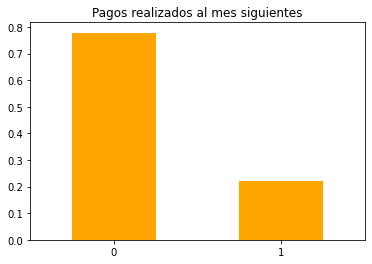

In [9]:
count_classes.plot(kind='bar', rot=0,color= 'Orange')
plt.title('Pagos realizados al mes siguientes')
plt.show()

Podemos notar que hay un desbalanceo de si y no avanzaremos para ver si este problema afecta mi modelo

In [10]:
df.describe()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
count,29965.000000,29965.000000,29965.000000,29965.000000,29965.000000,29965.000000,29965.000000,29965.000000,29965.000000,29965.000000,...,29965.000000,29965.000000,29965.000000,29965.000000,2.996500e+04,29965.000000,29965.000000,29965.000000,29965.000000,29965.000000
mean,167442.005006,1.603738,1.853629,1.551877,35.487969,-0.016753,-0.131854,-0.164392,-0.218922,-0.264509,...,43313.329885,40358.334390,38917.012281,5670.099316,5.927983e+03,5231.688837,4831.617454,4804.897047,5221.498014,0.221258
std,129760.135222,0.489128,0.790411,0.521997,9.219459,1.123492,1.196322,1.195878,1.168175,1.132220,...,64353.514373,60817.130623,59574.147742,16571.849467,2.305346e+04,17616.361124,15674.464538,15286.372298,17786.976864,0.415101
min,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2360.000000,1787.000000,1262.000000,1000.000000,8.500000e+02,390.000000,300.000000,261.000000,131.000000,0.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,19081.000000,18130.000000,17124.000000,2102.000000,2.010000e+03,1804.000000,1500.000000,1500.000000,1500.000000,0.000000
75%,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,54601.000000,50247.000000,49252.000000,5008.000000,5.000000e+03,4512.000000,4016.000000,4042.000000,4000.000000,0.000000
max,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.000000,621000.000000,426529.000000,528666.000000,1.000000


No hay ninguna anomalia en los datos por ello continuamos con nuestro analisis 

**Visualizaciones**

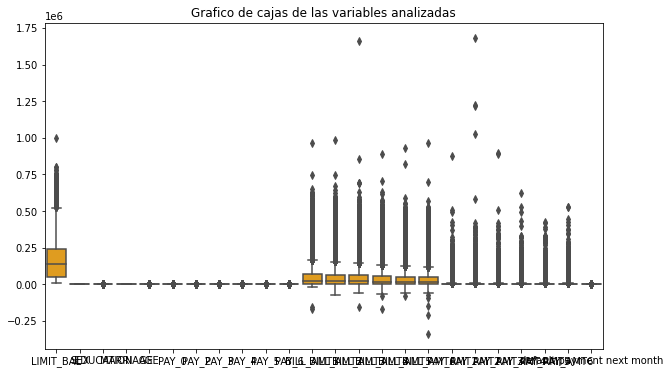

In [11]:
# solucion
plt.figure(figsize=(10, 6))
sns.boxplot(data=df,color='Orange')
plt.title('Grafico de cajas de las variables analizadas')
plt.show()

En este grafico, podemos ver que hay outlier en las variables pero ellos se puede explicar por la variabilidad de los resultados y seria consultar estos resultados a la persona especializada

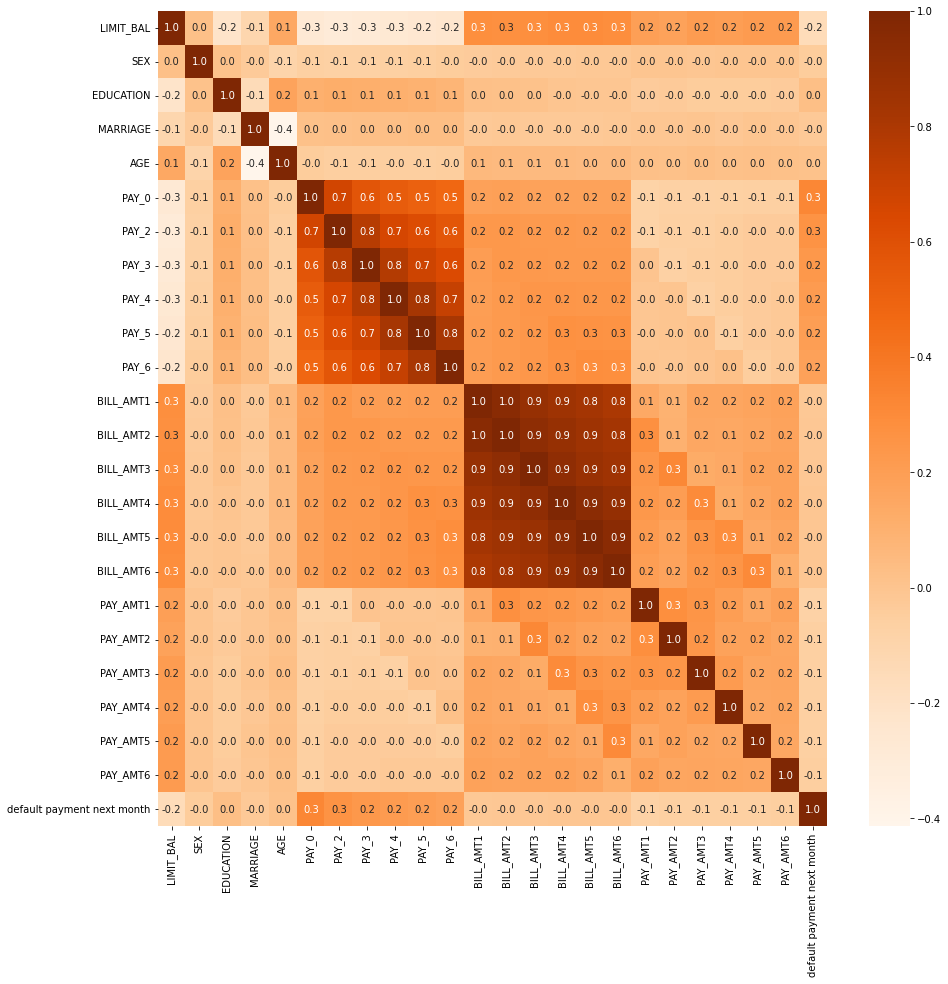

In [12]:
corr=df.corr()
fig, ax = plt.subplots(figsize = (15, 15))
sns.heatmap(corr, cmap = 'Oranges', annot = True, fmt=".1f", ax = ax)


El grafico de correlacion podemos ver la correlacion de nuestra variable objetivo con las demas variables, ahi notamos que no hay mucha correlacion entre estos pero notamos que en las variables de estado de pago del 2005 de abril y setiembre hay alta correlacion entre ellos

Text(0.5, 1.0, 'Clientes que pagaron su trajeta de credito  segun sexo')

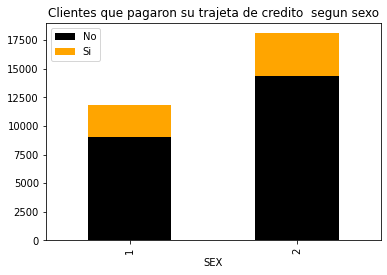

In [76]:
agr = df.groupby(['SEX','default payment next month']).size().reset_index().pivot(columns='default payment next month', index='SEX', values=0)
agr.plot(kind='bar', stacked=True, color={1:'orange',0:'black'})
plt.legend(['No','Si'])
plt.title('Clientes que pagaron su trajeta de credito  segun sexo')

Text(0.5, 1.0, 'Clientes que pagaron su trajeta de credito segun estado civil')

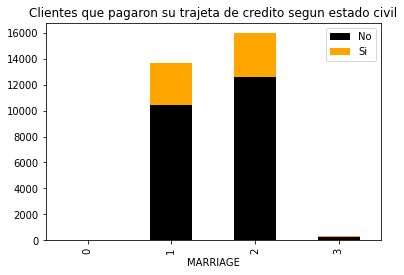

In [77]:
agr = df.groupby(['MARRIAGE','default payment next month']).size().reset_index().pivot(columns='default payment next month', index='MARRIAGE', values=0)
agr.plot(kind='bar',stacked=True,color={1:'orange',0:'black'})
plt.legend(['No','Si'])
plt.title('Clientes que pagaron su trajeta de credito segun estado civil')

Text(0.5, 1.0, 'Clientes que pagaron su trajeta de credito segun educacion')

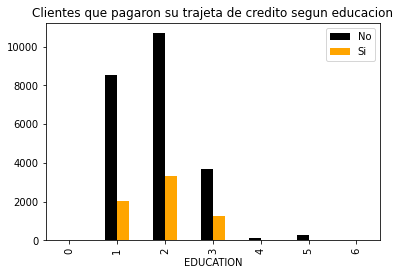

In [79]:
agr = df.groupby(['EDUCATION','default payment next month']).size().reset_index().pivot(columns='default payment next month', index='EDUCATION', values=0)
agr.plot(kind='bar', color={1:'orange',0:'black'})
plt.legend(['No','Si'])
plt.title('Clientes que pagaron su trajeta de credito segun educacion')

Text(0.5, 0, 'Setiembre')

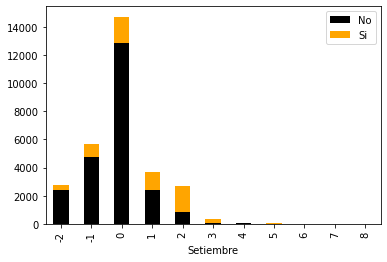

In [61]:
agr = df.groupby(['PAY_0','default payment next month']).size().reset_index().pivot(columns='default payment next month', index='PAY_0', values=0)
agr.plot(kind='bar', stacked=True,color={1:'orange',0:'black'})
plt.legend(['No','Si'])
plt.xlabel('Setiembre')

Text(0.5, 0, 'Agosto')

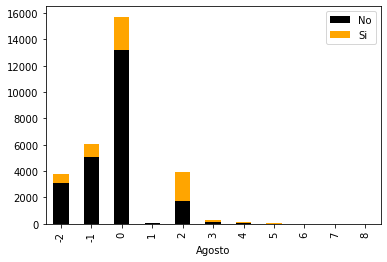

In [67]:
agr = df.groupby(['PAY_2','default payment next month']).size().reset_index().pivot(columns='default payment next month', index='PAY_2', values=0)
agr.plot(kind='bar', stacked=True,color={1:'orange',0:'black'})
plt.legend(['No','Si'])
plt.xlabel('Agosto')

Text(0.5, 0, 'Julio')

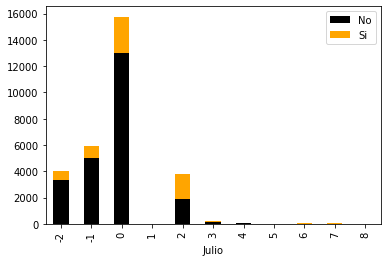

In [68]:
agr = df.groupby(['PAY_3','default payment next month']).size().reset_index().pivot(columns='default payment next month', index='PAY_3', values=0)
agr.plot(kind='bar', stacked=True,color={1:'orange',0:'black'})
plt.legend(['No','Si'])
plt.xlabel('Julio')

Text(0.5, 0, 'Junio')

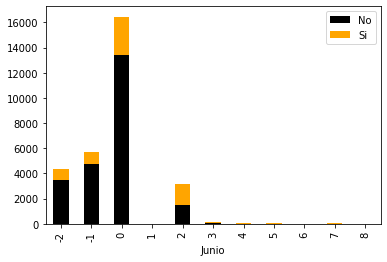

In [69]:
agr = df.groupby(['PAY_4','default payment next month']).size().reset_index().pivot(columns='default payment next month', index='PAY_4', values=0)
agr.plot(kind='bar', stacked=True,color={1:'orange',0:'black'})
plt.legend(['No','Si'])
plt.xlabel('Junio')

Text(0.5, 0, 'Mayo')

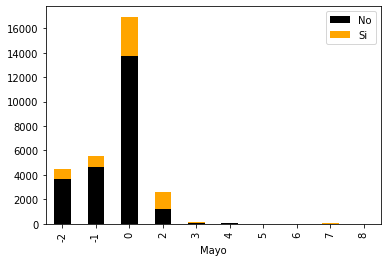

In [70]:
agr = df.groupby(['PAY_5','default payment next month']).size().reset_index().pivot(columns='default payment next month', index='PAY_5', values=0)
agr.plot(kind='bar', stacked=True,color={1:'orange',0:'black'})
plt.legend(['No','Si'])
plt.xlabel('Mayo')

Text(0.5, 0, 'Abril')

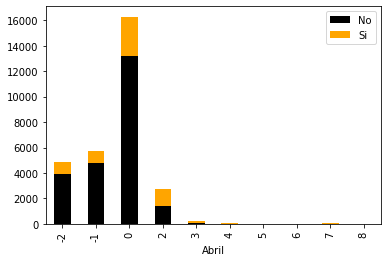

In [71]:
agr = df.groupby(['PAY_6','default payment next month']).size().reset_index().pivot(columns='default payment next month', index='PAY_6', values=0)
agr.plot(kind='bar', stacked=True,color={1:'orange',0:'black'})
plt.legend(['No','Si'])
plt.xlabel('Abril')

Text(0.5, 1.0, 'Clientes que pagaron su trajeta de crediton segun edad')

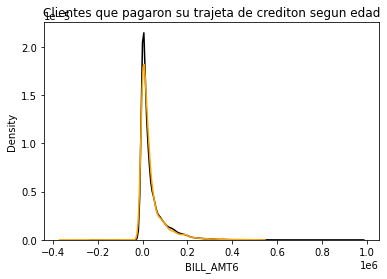

In [93]:
df1 = df[df['default payment next month']==0]
df2 = df[df['default payment next month']==1]

sns.kdeplot(df1['BILL_AMT6'],color='black')
sns.kdeplot(df2['BILL_AMT6'],color='orange')
plt.title('Clientes que pagaron su trajeta de crediton segun edad')

Text(0.5, 0, 'Setiembre')

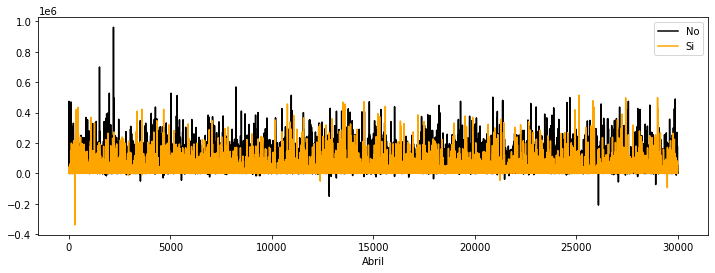

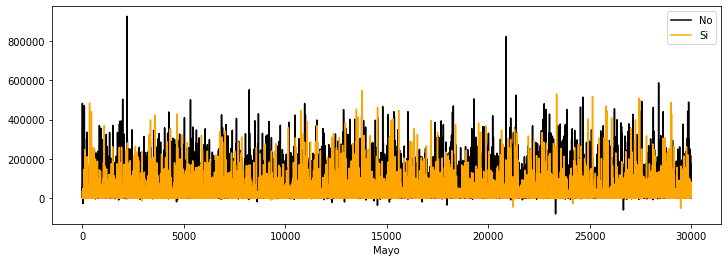

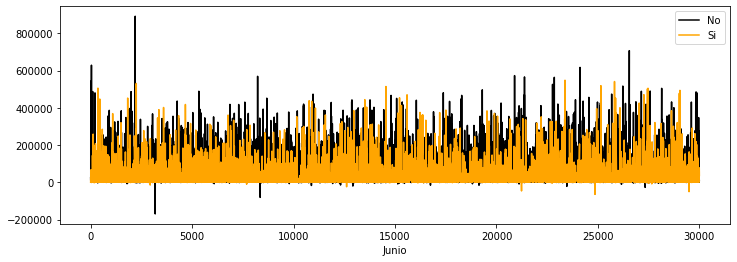

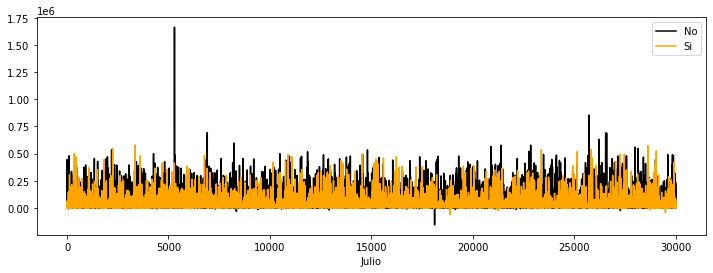

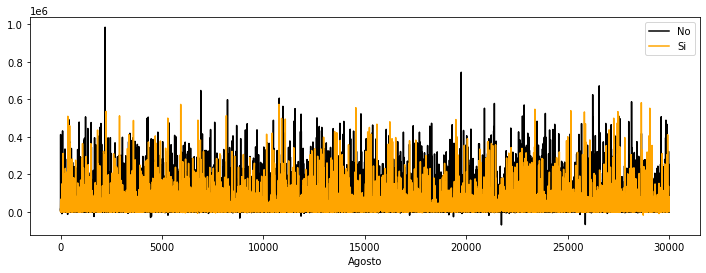

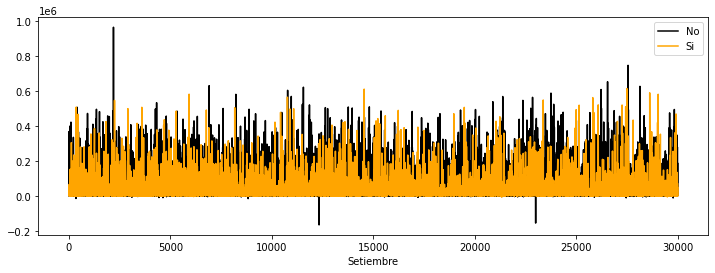

In [101]:
plt.subplots(figsize = (12, 4))

plt.plot(df1['BILL_AMT6'],color='black')
plt.plot(df2['BILL_AMT6'],color='orange')
plt.legend(['No','Si'])
plt.xlabel('Abril')

plt.subplots(figsize = (12, 4))

plt.plot(df1['BILL_AMT5'],color='black')
plt.plot(df2['BILL_AMT5'],color='orange')
plt.legend(['No','Si'])
plt.xlabel('Mayo')

plt.subplots(figsize = (12, 4))

plt.plot(df1['BILL_AMT4'],color='black')
plt.plot(df2['BILL_AMT4'],color='orange')
plt.legend(['No','Si'])
plt.xlabel('Junio')

plt.subplots(figsize = (12, 4))

plt.plot(df1['BILL_AMT3'],color='black')
plt.plot(df2['BILL_AMT3'],color='orange')
plt.legend(['No','Si'])
plt.xlabel('Julio')

plt.subplots(figsize = (12, 4))

plt.plot(df1['BILL_AMT2'],color='black')
plt.plot(df2['BILL_AMT2'],color='orange')
plt.legend(['No','Si'])
plt.xlabel('Agosto')

plt.subplots(figsize = (12, 4))
plt.plot(df1['BILL_AMT1'],color='black')
plt.plot(df2['BILL_AMT1'],color='orange')


plt.legend(['No','Si'])
plt.xlabel('Setiembre')

Text(0.5, 0, 'Setiembre')

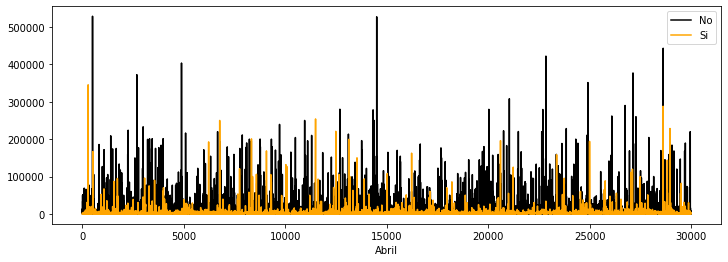

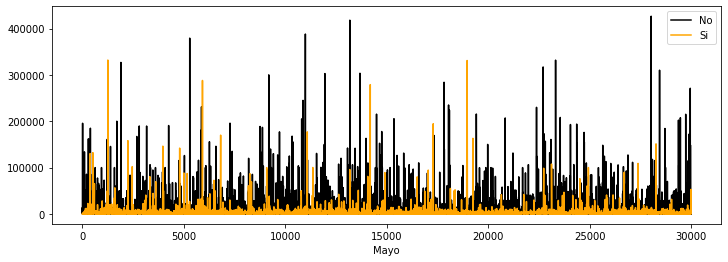

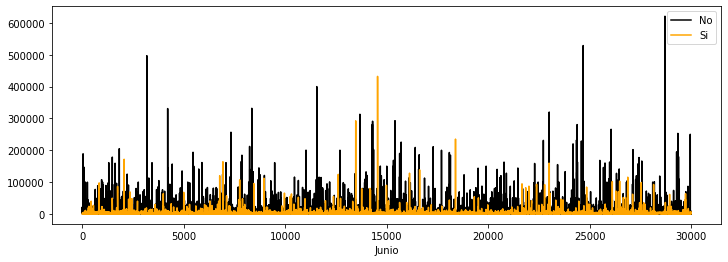

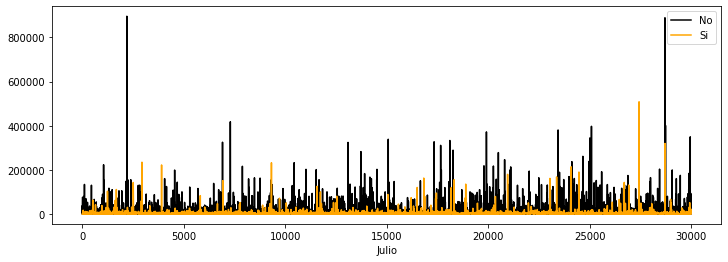

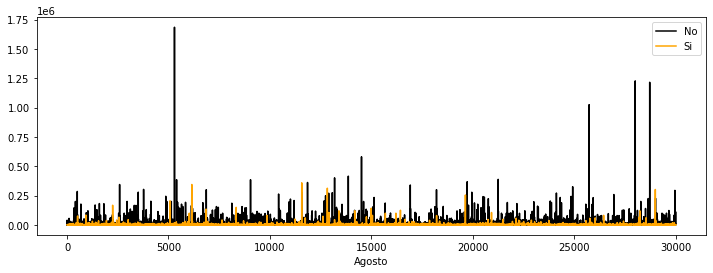

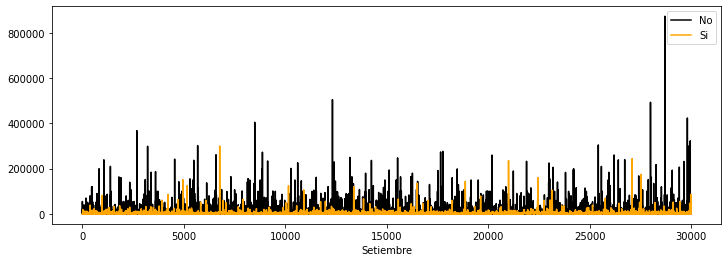

In [102]:
plt.subplots(figsize = (12, 4))

plt.plot(df1['PAY_AMT6'],color='black')
plt.plot(df2['PAY_AMT6'],color='orange')
plt.legend(['No','Si'])
plt.xlabel('Abril')

plt.subplots(figsize = (12, 4))

plt.plot(df1['PAY_AMT5'],color='black')
plt.plot(df2['PAY_AMT5'],color='orange')
plt.legend(['No','Si'])
plt.xlabel('Mayo')

plt.subplots(figsize = (12, 4))

plt.plot(df1['PAY_AMT4'],color='black')
plt.plot(df2['PAY_AMT4'],color='orange')
plt.legend(['No','Si'])
plt.xlabel('Junio')

plt.subplots(figsize = (12, 4))

plt.plot(df1['PAY_AMT3'],color='black')
plt.plot(df2['PAY_AMT3'],color='orange')
plt.legend(['No','Si'])
plt.xlabel('Julio')

plt.subplots(figsize = (12, 4))

plt.plot(df1['PAY_AMT2'],color='black')
plt.plot(df2['PAY_AMT2'],color='orange')
plt.legend(['No','Si'])
plt.xlabel('Agosto')

plt.subplots(figsize = (12, 4))
plt.plot(df1['PAY_AMT1'],color='black')
plt.plot(df2['PAY_AMT1'],color='orange')


plt.legend(['No','Si'])
plt.xlabel('Setiembre')

In [ ]:
#more side-by-side comparisons
fig, (maxis1, maxis2) = plt.subplots(1, 2,figsize=(12,6))

#how does family size factor with sex & survival compare
sns.pointplot(x=df['EDUCATION'], y=df['LIMIT_BAL'], hue=df['default payment next month'], data=df,
              palette={0: 'black', 1: 'Orange'},
              markers=["*", "o"], linestyles=["-", "--"], ax = maxis1)

#how does class factor with sex & survival compare
sns.pointplot(x=df['MARRIAGE'], y=df['LIMIT_BAL'], hue=df['default payment next month'], data=df,
              palette={0: 'black', 1: 'Orange'},
              markers=["*", "o"], linestyles=["-", "--"], ax = maxis2)


plt.show()

In [ ]:
from seaborn.widgets import color_palette
#histogram comparison of sex, class, and age by survival
h = sns.FacetGrid(df, row = 'SEX', col = 'EDUCATION', hue = 'default payment next month',
                  palette={0: 'black', 1: 'Orange'})
h.map(plt.hist, 'AGE', alpha = .75)
h.add_legend()

plt.show()

**Particionamiento de datos**

In [ ]:
le = LabelEncoder()
y = le.fit_transform(df['default payment next month'])

X = df.drop(columns = 'default payment next month')

In [ ]:
under= NearMiss(sampling_strategy=0.85)
x_t_under, y_t_under = under.fit_resample(X,y)
pd.value_counts(y_t_under)

In [ ]:
x_t_under = pd.DataFrame(x_t_under, columns=list(df.columns[0:23]))
x_t_under.head()

In [ ]:
y_t_under = pd.DataFrame(y_t_under, columns=['y'])
y_t_under.head()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x_t_under, y_t_under, random_state=42)

In [ ]:
X_train

**Escalamiento de los datos**

Analizando los datos notamos que no hay variables categoricas en las variables dependientes, solo tenemos nuestra variable objetivo que es categorica pero ya esta codificada.
Por otro lado, comenzaremos el escalamiento de datos que yo lo realizare antes de realizar las particion de datos 

In [ ]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

Realizare este paso de escalamiento sin el pipeline ya que no tenemos que imputar ya que estos datos no presentan nulos 

**PCA**

Realizaremos la reduccion de dimension por que vemos que tenemos muchas dimension 

In [ ]:
pca = PCA(n_components=.95)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

### II.- Modelos


Los modelos que probaremos es los de prediccion ya que nuestra variable objetivo es una categorica (0:no,1:si)

**Arbol de decision**

In [ ]:
# Arboles de decisiones
dec_tree = DecisionTreeClassifier(random_state = 42, max_depth=2)
dec_tree.fit(X_train, y_train)
#dec_tree_pipe.fit(X_train, y_train)
predict_dec_tree=dec_tree.predict(X_test)
predict_dec_tree_train=dec_tree.predict(X_train)
train_score = dec_tree.score(X_train, y_train)
test_score = dec_tree.score(X_test, y_test)
print(train_score)
print(test_score)

**Regresion Logistica**

In [ ]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
predict_logreg=logreg.predict(X_test)
predict_logreg_train=logreg.predict(X_train)
print(logreg.score(X_train, y_train))
print(logreg.score(X_test, y_test))

En este modelo realizaremos una mejora en el hiperparametro para ver si se mejora los resultados

In [ ]:
# create a list of c values and empty lists for scores
c_values = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
train_scores = []
test_scores = []
#iterative over the c values
for c in c_values:
 
  # instantiate a model with each value of c and fit it on the data
  log_reg = LogisticRegression(C=c, max_iter=1000, solver='liblinear', penalty='l1')
  log_reg.fit(X_train, y_train)
 
  # add the training and testing scores to our scores lists
  train_scores.append(log_reg.score(X_train, y_train))
  test_scores.append(log_reg.score(X_test, y_test))
 
#plot the change in accuracy as we change the value of C
fig, ax = plt.subplots(1,1)
ax.plot(c_values, train_scores, label='Training Accuracy')
ax.plot(c_values, test_scores, label='Testing Accuracy')
ax.set_xticks(c_values)
ax.set_title('Change in accuracy over C values for l1 regularization')
ax.legend()
 
#set the x axis to a logarithmic scale to show the values of C in even intervals
ax.set_xscale('log')
# print a dictionary of values of C and accuracy scores
{c:score for c, score in zip(c_values, test_scores)}

In [ ]:
# create a list of c values and empty lists for scores
c_values = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
train_scores = []
test_scores = []
#iterative over the c values
for c in c_values:
  # instantiate a model with each value of c and fit it on the data
  log_reg = LogisticRegression(C=c, max_iter=1000, solver='liblinear', penalty='l2')
  log_reg.fit(X_train, y_train)
 
  # add the training and testing scores to our scores lists
  train_scores.append(log_reg.score(X_train, y_train))
  test_scores.append(log_reg.score(X_test, y_test))
  
#plot the change in accuracy as we change the value of C
fig, ax = plt.subplots(1,1)
ax.plot(c_values, train_scores, label='Training Accuracy')
ax.plot(c_values, test_scores, label='Testing Accuracy')
ax.set_xticks(c_values)
ax.set_title('Change in accuracy over C values for l2 regularization')
ax.legend()
#set the x axis to a logarithmic scale to show the values of C in even intervals
ax.set_xscale('log')
# print a dictionary of values of C and accuracy scores
{c:score for c, score in zip(c_values, test_scores)}

De los dos que se propone para mejorar los resultados, vemos que la L1 con 1 tenemos 0.81 que es nuestra mejor opcion para el mejoramiento

Aca despues de realizar la prueba nos damos cuenta que el resultado sin mejorar el parametro y con la mejora es igual 

**Metodo Bagging**

In [ ]:
bagcl = BaggingClassifier(random_state = 42)
bagcl.fit(X_train, y_train)
predict_bagcl=bagcl.predict(X_test)
predict_bagcl_train=bagcl.predict(X_train)
bagcl_train_score = bagcl.score(X_train, y_train)
bagcl_test_score = bagcl.score(X_test, y_test)
print(bagcl_train_score)
print(bagcl_test_score)

**Bosque aleatorios**

In [ ]:
rf = RandomForestClassifier(random_state = 42)
rf.fit(X_train, y_train)
predict_rf=rf.predict(X_test)
predict_rf_train=rf.predict(X_train)
rf_train_score = rf.score(X_train, y_train)
rf_test_score = rf.score(X_test, y_test)
print(rf_train_score)
print(rf_test_score)

**Metodo KNN**

In [ ]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
Predict_knn = knn.predict(X_test)
Predict_knn_train = knn.predict(X_train)
knn_train_score = knn.score(X_train, y_train)
knn_test_score = knn.score(X_test, y_test)
print(knn_train_score)
print(knn_test_score)

**Redes Neuronales**

In [ ]:
input_shape = X_train.shape[1]
input_shape

In [ ]:
# Without dropout
# Sequential model
model = Sequential()
# First hidden layer
model.add(Dense(23, # How many neurons you have in your first hidden layer
                input_dim = input_shape, # What is the shape of your input features (number of columns)
                activation = 'relu')) # What activation function are you using?
model.add(Dense(10, 
                activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(loss = 'bce', optimizer = 'adam', metrics = ['acc'])

history = model.fit(X_train, y_train,
                    validation_data = (X_test, y_test), 
                    epochs=10)

In [ ]:
#Perdida:
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.legend();

In [ ]:
#metrica
plt.plot(history.history['acc'], label='Train Acc')
plt.plot(history.history['val_acc'], label='Test Acc')
plt.legend();

In [ ]:
# Without dropout
# Sequential model
model = Sequential()
# First hidden layer
model.add(Dense(15, # How many neurons you have in your first hidden layer
                input_dim = input_shape, # What is the shape of your input features (number of columns)
                activation = 'tanh')) # What activation function are you using?
#model.add(Dropout(.1))
model.add(Dense(10, 
                activation = 'tanh'))
#model.add(Dropout(.1))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(loss = 'bce', optimizer = 'adam', metrics = ['acc'])
early_stopping = EarlyStopping(patience = 5)

history = model.fit(X_train, y_train,
                    validation_data = (X_test, y_test), 
                    epochs=100,
                    callbacks = [early_stopping])

In [ ]:
#Perdida:
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.legend();


In [ ]:
#metrica
plt.plot(history.history['acc'], label='Train Acc')
plt.plot(history.history['val_acc'], label='Test Acc')
plt.legend();

### III.- Validacion de los Modelos

In [ ]:
# evaluate model
print('Redes Neuronales')
#make predictions
y_preds = model.predict(X_test)
y_preds_train = model.predict(X_train)


# round the predictions
y_preds = np.round(y_preds)
y_preds_train = np.round(y_preds_train)

# Check the model performance

print(classification_report(y_test, y_preds))
print(classification_report(y_train, y_preds_train)) 

ConfusionMatrixDisplay.from_predictions(y_test, y_preds, cmap='Oranges');
ConfusionMatrixDisplay.from_predictions(y_train, y_preds_train, cmap='Oranges');

In [ ]:
print(f'Training AUC: {roc_auc_score(y_train, y_preds_train)}')
print(f'Testing AUC: {roc_auc_score(y_test, y_preds)}')

In [ ]:
print('Arboles de desicion')
print(classification_report(y_test, predict_dec_tree))
cm = confusion_matrix(y_test,predict_dec_tree, labels=dec_tree.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=dec_tree.classes_ )

disp.plot()

print('Arboles de desicion TRAIN')
print(classification_report(y_train, predict_dec_tree_train))
cm1 = confusion_matrix(y_train,predict_dec_tree_train, labels=dec_tree.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm1,
                               display_labels=dec_tree.classes_ )

disp.plot()

In [ ]:
print(f'Training AUC: {roc_auc_score(y_train, dec_tree.predict_proba(X_train)[:,1])}')
print(f'Testing AUC: {roc_auc_score(y_test, dec_tree.predict_proba(X_test)[:,1])}')
RocCurveDisplay.from_estimator(dec_tree, X_train, y_train)
plt.plot([0, 1], [0, 1], ls = '--', label = 'Baseline (AUC = 0.5)')
plt.legend();

In [ ]:
print('Regresion Logistica')
print(classification_report(y_test,predict_logreg ))
cm = confusion_matrix(y_test,predict_logreg, labels=logreg.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=logreg.classes_)
disp.plot()

print('Regresion Logistica Train')
print(classification_report(y_train,predict_logreg_train ))
cm = confusion_matrix(y_train,predict_logreg_train, labels=logreg.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=logreg.classes_)
disp.plot()

In [ ]:
print(f'Training AUC: {roc_auc_score(y_train, logreg.predict_proba(X_train)[:,1])}')
print(f'Testing AUC: {roc_auc_score(y_test, logreg.predict_proba(X_test)[:,1])}')
RocCurveDisplay.from_estimator(logreg, X_train, y_train)
plt.plot([0, 1], [0, 1], ls = '--', label = 'Baseline (AUC = 0.5)')
plt.legend();

In [ ]:
print('Bagging')
print(classification_report(y_test, predict_bagcl))
cm = confusion_matrix(y_test,predict_bagcl, labels=bagcl.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=bagcl.classes_)
disp.plot()

print('Bagging train')
print(classification_report(y_train, predict_bagcl_train))
cm = confusion_matrix(y_train,predict_bagcl_train, labels=bagcl.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=bagcl.classes_)
disp.plot()

In [ ]:
print(f'Training AUC: {roc_auc_score(y_train, bagcl.predict_proba(X_train)[:,1])}')
print(f'Testing AUC: {roc_auc_score(y_test, bagcl.predict_proba(X_test)[:,1])}')
RocCurveDisplay.from_estimator(bagcl, X_train, y_train)
plt.plot([0, 1], [0, 1], ls = '--', label = 'Baseline (AUC = 0.5)')
plt.legend();

In [ ]:
print('ramdom forest')
print(classification_report(y_test, predict_rf))
cm = confusion_matrix(y_test,predict_rf, labels=rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=rf.classes_)
disp.plot()

print('ramdom forest')
print(classification_report(y_train, predict_rf_train))
cm = confusion_matrix(y_train,predict_rf_train, labels=rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=rf.classes_)
disp.plot()

In [ ]:
print(f'Training AUC: {roc_auc_score(y_train, rf.predict_proba(X_train)[:,1])}')
print(f'Testing AUC: {roc_auc_score(y_test, rf.predict_proba(X_test)[:,1])}')
RocCurveDisplay.from_estimator(rf, X_train, y_train)
plt.plot([0, 1], [0, 1], ls = '--', label = 'Baseline (AUC = 0.5)')
plt.legend();

In [ ]:
print('KNN')
print(classification_report(y_test, Predict_knn))
cm = confusion_matrix(y_test,Predict_knn, labels=knn.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=knn.classes_)
disp.plot()

print('KNN')
print(classification_report(y_train, Predict_knn_train))
cm = confusion_matrix(y_train,Predict_knn_train, labels=knn.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=knn.classes_)
disp.plot()

In [ ]:
print(f'Training AUC: {roc_auc_score(y_train, knn.predict_proba(X_train)[:,1])}')
print(f'Testing AUC: {roc_auc_score(y_test, knn.predict_proba(X_test)[:,1])}')
RocCurveDisplay.from_estimator(knn, X_train, y_train)
plt.plot([0, 1], [0, 1], ls = '--', label = 'Baseline (AUC = 0.5)')
plt.legend();

## Conclusiones

* Realizando las modificaciones al modelos nos damos cuenta que el mejor modelo para estos datos seria redes neuronales, pero como segunda opcion nos quedariamos con regresion logistica, depente del costo que tomaria a la empresa y cual modelo este dentro de su presupuesto.




## Referencias

* [Curso CodingDojo-DataScience](https://github.com/fralfaro/CodingDojo-DataScience)